## Titianic Data Analysis Project

### Overview
* Question
* Loading and Initial Observation
* Explore
* Draw Conclusions


<h3 id="libAndData"> 1. Questions </h3>

A brief overview of the data is given from The [Kaggle Project Page](https://www.kaggle.com/c/titanic). Some points from this overview:

On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew
One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew

Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

The main goal will be to answer the question: Who is the most likely to survive?

<h3 id="libAndData">2. Libraries and Loading Data</h3>

In [3]:
import numpy as np
import pandas as pd
from scipy import stats, integrate
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline
# Visual
import seaborn as sns
sns.set(color_codes=True)
# Load data
titanic_df = pd.read_csv('titanic-data.csv')

<h4 id="lib">2.2 Loading Data</h4>

In [5]:
pd.options.display.float_format = '{:.0f}'.format

<h4 id="ColNames">2.3 Dataset Column Headers</h4>
The column names of the data frame are printed out in order to to determine if the dataset was imported fully and so that it is easy to reference the column names.

In [7]:
# View Data
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,8,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8,NaN,S


In [8]:
titanic_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [6]:
#get the column names
list(titanic_df)

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked']

<h3 id="PrimaryQuestion">4. Primary Question</h3>
The primary question that will be reviewed with this data set is what variables are able to help perdict survival rate. The variables that will be reviewed are those listed in the column names above. While this project isn't necessary going to go into creating a predictive model for survival rates on the titanic, it will provide a general idea of which variables would be integral in setting up this algorithm.

<h3 id="Pre">5. Preliminary Data Wrangling/Cleaning</h3>
Due to this dataset being from Kaggle it is unlikely that the data will be "dirty" per say, but it is always a good idea to look through the data to see if there is anything unexpected. This is also a good way to become more familiar with the data, so answering the question will be easier and it will be unlikely that a wrong interpretation of the data will arise by accident. 

There are a good deal of missing values in the data. Embarked appears to be the simplest to deal with. Observing the entries with missing values leads to some conclusions. It looks like these two passengers roomed in the same cabin with the same ticket and fare. It is safe to assume that they left from the same port.



In [9]:
titanic_df[titanic_df.Embarked.isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38,0,0,113572,80,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62,0,0,113572,80,B28,NaN


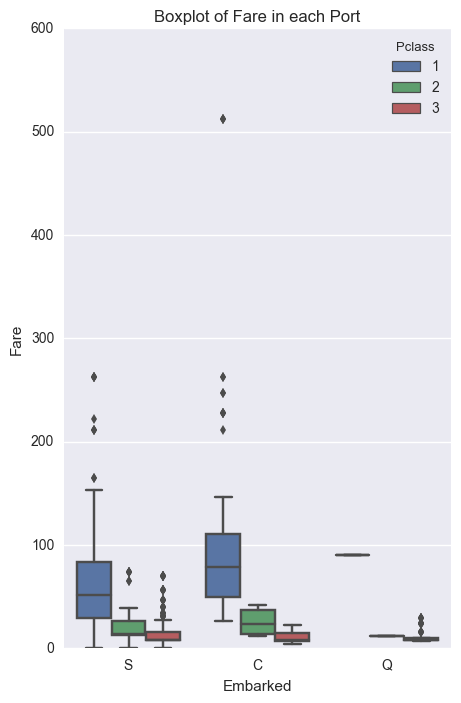

In [12]:
# Plot to get an idea of spread of data
plt.figure(figsize=(5, 8))
plot = plt.subplot(111)
sns.boxplot(titanic_df['Embarked'], titanic_df['Fare'],hue=titanic_df['Pclass'])
plot.set_title('Boxplot of Fare in each Port')

<h4 id="checkFunctions">5.0 Functions</h4>
The following functions will be used through this section.

In [10]:
def countByGroup(df, group):    
    #Summary:Check the number of people that survived and see if any unexpected values come up
        #turn it into a dataframe so that we can print it out nicely.
    #Input-
        #df - a dataframe of the titanic data
        #group - a stromg of the group that is the dataframe is being grouped by
    #Output- dataframe of the count of each varible in the column
    tb = pd.DataFrame(titanic_df.groupby(group).size())
    #fix the dataframe so it prints out nice by default
    tb.columns = ['Count']
    tb.index.name = None
    tb.columns.name = group
    return(tb)

def isAgeEstimate(age):
    #Summary: Check to see if the age is an estimate
    #Input: Float or NAN (represents the age. Should be a positive number)
    #Output: Boolean (True if the age is not an estimate. False if it is an estimate or NAN if it is NAN)
    
    #If it is nan we are returning true. we do this first to avoid the issues of NAN being evaluated later on
    if pd.isnull(age): 
        return(np.nan)
    #If the age is less than 1 then is a baby, so it isn't considered an estimate
    elif age < 1:
        return(False)
    #If the age minus the age rounded down is greater than 0 it means that the age must contain a .5 and therefore is an estimate
    elif (age-np.floor(age)) > 0:
        return(True)
    #Everything else should not be an estimate
    else:
        return(False)

<h4 id="Null">5.1 Null Values</h4>
One important item to check for is to see if there are any null values in each column. To do this we can run the following code:

In [11]:
#check for null values and sum it up for each column
tb = pd.DataFrame(titanic_df.isnull().sum())
#fix the dataframe so it prints out nice by default
tb.columns = ['Count']
tb.index.name = None
tb.columns.name = 'Pclass'
tb

Pclass,Count
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


It appears that age, cabin, and embarked all have null values in them. This will need to be kept in mind when investigating the data latter on.

<h4 id="PassengerIDCheck">5.2 PassengerID</h4>
The 'PassengerID' column is supposed to be the unique ID for each passenger in the table, so there should be no duplicates or null values. Above it was confirmed that there is no null values in PassengerId, so now a check for duplicates will be performed.

In [6]:
#check for duplicates in passengerID
print("Duplicates in PassengerID:", titanic_df.duplicated('PassengerId').sum())

Duplicates in PassengerID: 0


Since there is no duplicates or null values in PassengerID it appears that PassengerID is functioning as expected for this dataset.

<h4 id="TotalPassengers">5.3 Number of Passengers</h4>
By counting the number of rows in PassengerID the number of passengers will be gotten. This can be useful information to know when examining the data.

In [7]:
#count the number of rows we have
print("Number of Rows:",titanic_df.duplicated('PassengerId').count())

Number of Rows: 891


<h4 id="SurvivedCheck">5.4 Survived</h4>
The survived column should only have two values. In order to check this a count can be performed for each variable in the column. If an unexpected value comes up it will appear along with the 0 and 1's.

In [8]:
#Check the count of each variable in survivied
countByGroup(titanic_df,"Survived")

Survived,Count
0,549
1,342


As shown in the table above this column contains the data as expected.

<h4 id="PclassCheck">5.5 Pclass</h4>
The Pclass as described by Kaggle is 'A proxy for socio-economic status (SES)'. This proxy is described with 3 numbers were 1 is the upper class, 2 is the middle class, and 3 is the lower class. It has a li

In [9]:
#Check the count of each variable in Pclass
countByGroup(titanic_df,"Pclass")

Pclass,Count
1,216
2,184
3,491


Pclass appears as expected.

<h4 id="NameCheck">5.6 Name</h4>
The name column contains the names of each person on the titanic. This analysis will not use the names. However, the names will still be checked for duplicates. If there is a duplicate name further exploration will be needed in order to figure out if it is a repeat data point.

In [10]:
#check for duplicates in Name
print("Duplicates in Name:", titanic_df.duplicated('Name').sum())

Duplicates in Name: 0


There are 0 duplicate names therefore it will be assumed that there are no duplicate rows.

<h4 id="SexCheck">5.7 Sex</h4>

In [11]:
#Check the count of each variable in Sex
countByGroup(titanic_df,"Sex")

Sex,Count
female,314
male,577


These counts and variables are with expectations. 

<h4 id="AgeCheck">5.7 Age</h4>
The age column is a numeric column with a large number of possibily values this means that it would not be practical to print out the count for each variable. Instead the range of ages will be checked to ensure that the ages make sense.

In [12]:
print('The minimum age is:', titanic_df['Age'].min())
print('The maximum age is:', titanic_df['Age'].max())

The minimum age is: 0.42
The maximum age is: 80.0


The minimum and maximum are within a reasonable bound. As noted by Kaggle anyone under the age of one has a fraction as their age, but anyone over the age of one that is listed in the format XX.5 has an estimated age. In case it is needed latter on a column will be created that is false when the age is not an estimate and true when it is an estimate. (Null values will continue to be null)

In [13]:
#create a column that will hold if the age is an estimate or not
titanic_df['AgeIsEstimate'] = titanic_df['Age'].apply(isAgeEstimate)

print('Number of Ages Estimated:',np.sum(titanic_df['AgeIsEstimate']))

Number of Ages Estimated: 18


As calculated above we know 177 ages are NaN and 18 are estimates, so there is 696 confirmed ages.

<h4 id="SibSpCheck">5.8 SibSp</h4>
It is fairly unlikely to have more than 10 of siblings/spouses it is possible to do a simple count of the values within the column to check for any abnormalities.

In [14]:
#Check the count of each value in SibSp
countByGroup(titanic_df,"SibSp")

SibSp,Count
0,608
1,209
2,28
3,16
4,18
5,5
8,7


Again this column does not appear to have any unforeseen issues.

<h4 id="ParchCheck">5.9 Parch</h4>
The column of the number of parents/children aboard the Titanic can be checked similar to the SibSp column.

In [15]:
#Check the count of each value in Parch
countByGroup(titanic_df,"Parch")

Parch,Count
0,678
1,118
2,80
3,5
4,4
5,5
6,1


These counts are reasonable.

<h4 id="TicketsCheck">5.10 Tickets</h4>
There is not much that is possible to check in this column.However, it might be useful to check the frequency of the number of people that have the same ticket id.

In [16]:
#Some of the passangers are on the same ticket, so the first step is to count the number if passengers per ticket
tb = countByGroup(titanic_df,"Ticket")
#There are still to many records to reasonable look at, so it will be reduced to the a 
#frequency of the number of people on a ticket
tb.columns = ['NumPassWithSameTicket']

#add this information to the dataframe for later use.
titanic_df = titanic_df.merge(tb, left_on='Ticket', right_index=True, how='left')

tb = pd.DataFrame(tb.groupby('NumPassWithSameTicket').size())
#fix the dataframe so it prints out nice by default
tb.columns = ['Frequency']
tb.index.name = None
tb.columns.name = 'Number of Passengers with the same Ticket ID'
tb


Number of Passengers with the same Ticket ID,Frequency
1,547
2,94
3,21
4,11
5,2
6,3
7,3


<h4 id="FareCheck">5.11 Fare</h4>
Fare should be a positive number to some finite amount. Since there will not be a limited amount of possible values in this column it is reasonable to only check the min and max.

In [17]:
print('The minimum fare is:', titanic_df['Fare'].min())
print('The maximum fare is:', titanic_df['Fare'].max())

The minimum fare is: 0.0
The maximum fare is: 512.3292


This range seems to be correct, but the decimal places is odd since the US dollar should only have 2 places. This was most likely due to Kaggle using some algorithm to normalize the fare to ensure it was all in one currency. It will be assumed that Kaggle knew what it was doing in this algorithm and the data is correct.

<h4 id="CabinCheck">5.12 Cabin</h4>
Cabin is hard to do an easy check for. The easiest thing to look at is the frequency of the number of people in a cabin. If there is a value that contains too many people (more than 8) it should be investigated.

In [18]:
#Some of the passangers are on the same ticket, so the first step is to count the number if passengers per Cabin
tb = countByGroup(titanic_df,"Cabin")
#There are still to many records to reasonable look at, so it will be reduced to the a 
#frequency of the number of people on a Cabin
tb = pd.DataFrame(tb.groupby('Count').size())

#fix the dataframe so it prints out nice by default
tb.columns = ['Frequency']
tb.index.name = None
tb.columns.name = 'Number of People in a Cabin'
tb

Number of People in a Cabin,Frequency
1,101
2,38
3,5
4,3


The number of people in each cabin appears to be reasonable.

<h4 id="EmbarkedCheck">5.13 Embarked</h4>
By Kaggles definition of this column there is only three expected values. Therefore a simple count of each of the values in this column should suffice.

In [19]:
#Check the count of each variable in Embarked
countByGroup(titanic_df,"Embarked")

Embarked,Count
C,168
Q,77
S,644


There are only three values, so this column appears as expected.

<h4 id="SectionSummaryCheck">5.13 Section Summary</h4>
The following columns had their data appear as expected and will be used in the next section:

* PassengerId
* Survived
* Pclass
* Sex
* Age - It should be noted that this column has 177 null values and 18 estimated ages. A additional column called AgeIsEstimate was added that holds if the age was null (NaN), an estimate (TRUE), and known (FALSE).
* SibSp
* Parch
* Ticket - To properly analysis tickets would require some information beyond the scopre of this analysis. However, a new column called NumPassWithSameTicket will be used. This column holds the number of people with the same ticket id.
* Fare
* Embarked - This column has 2 null values.

The following columns will not be used in further analysis:
* Name - This data appeared as expected, but to properly use the Name column in the analysis information beyond the scope of this analysis should be used.  
* Cabin - This column has a large number of null values, which means that the data set corresponding to it is small. It can also be noted that fare and pclass will already somewhat account for cabin since they should be loosely correlated to cabin placement.


<h3 id="OneDimIntro">6. One Dimensional Analysis of Columns By Survival</h3>
This section is going to focus on looking at what columns might be predictors for survival. PassengerID is just a unique identifier and is only used to keep track of counts. The following columns will also not be examined for survival due to the the reasons mentioned in the summary of section 5: Name, and Cabin. To examine whether the columns might be predictors for survival two graphs will be generated to compare the number survived per column value and the percent survived per column values (ie in Embarked the column values are C, Q, and S). A table will also be generated that shows the number that survived and the percent of them that survived per column value. To accomplish this the following three functions will be used. Some columns will need additional work before they can be examined in the manner outlined above. Other columns also get grouped differently in order to see if there is a more efficient way of defining the data that can help predict survival.

<h4 id="OneDimFunctions">6.0 Functions</h4>

In [20]:
def autoLabelPercent(chart, rects):
    #Summary:Adds labels to bar charts that shows the height in percent
    #input: 
        #Chart - the overall chart/fig
        #rects - the individual bar chart
    #output: NA
    
    #cycle though each of the rectangles that make up the bar chart
    for rect in rects:
        #get the height of the rectangels
        height = rect.get_height()
        #add thier height as text on the top of each rectangle
        chart.text(rect.get_x() + rect.get_width()/2., 1.0*height,
                "{0:.2f}".format(height)+"%",
                ha='center', va='bottom')

In [21]:
def autoLabelNumber(chart, rects):
    #Summary:Adds labels to bar charts that shows the height in percent
    #input: 
        #Chart - the overall chart/fig
        #rects - the individual bar chart
    #output: NA
    
    #cycle though each of the rectangles that make up the bar chart
    for rect in rects:
        #get the height of the rectangels
        height = rect.get_height()
        #add thier height as text on the top of each rectangle
        chart.text(rect.get_x() + rect.get_width()/2., 1.0*height,
                "{0:.0f}".format(height),
                ha='center', va='bottom')

In [22]:
def createSurvivalTable(titanic_df, colToCompare):
    #Summary:Create a table of the totals and percentages of survival for each column value
    #input: 
        #titanic_df - the titanic data set
        #colToCompare - the column name we are compairing with survival rate
    #output: pd dataframe of the totals and percentages of survival for each column value  
    #Check the number of people that survived by the col we want to compare with
    #turn it into a dataframe for easier manipulation
    df = pd.DataFrame(titanic_df.groupby(['Survived',colToCompare])['PassengerId'].count())
    
    #Seperate the dataframe to those who survived and those taht did not
    x = pd.DataFrame(df['PassengerId'][1])
    y = pd.DataFrame(df['PassengerId'][0])
   
    #merge them together to make one nice table
    tb = pd.merge(x, y, left_index =True, right_index=True, how='outer')
    #give the columns proper names
    tb.columns = ['Number Survived', 'Number Lost']
    
    #Set nan to 0. This makes sense in this situation since we are counting the number
    tb = tb.fillna(value = 0)
    
    #Show the total for each row
    tb['Total'] = tb['Number Survived']+tb['Number Lost'] 

    #create a column to hold the percent that survived
    tb['Percent Survived'] = tb['Number Survived'] /tb['Total'] *100
    
    #create a column to hold the percent that survived
    tb['Percent Lost'] = tb['Number Lost'] /tb['Total'] *100
    tb=tb.round(decimals=0)
    return(tb)

In [23]:
def getBarChartOfPercentSurvived(df,chartTitle,chartWidth,chartHeight, legendLocation):
    #Summary:Gives a barchart for the percentage of those that survived vs those that didn't grouped by a chosen variable
    #input:
        #df - A pd dataframe of the count of the passangers grouped by survived and X variable
        #chartTitle - The title of the chart
        #chartWidth - Sets the width of the bar chart
        #chartHeight - Sets the height of the bar chart
    #output: A bar chart of the percent survived
    
    #Set graph size
    plt.rcParams['figure.figsize'] = (chartWidth, chartHeight)
    
    #Create the overall chart and setup the indices and the width of the rectangles
    fig, barChart = plt.subplots()
    ind = np.arange(len(df.index.values))
    width = 0.35

    #Create the the bar charts for the survived and those who did not survive
    survived = barChart.bar(ind, df['Percent Survived'], width, color = '#c4d79b')
    nSurvived = barChart.bar(ind+width, df['Percent Lost'], width, color = '#da9694')

    #Add some text for labels, title and axes ticks
    barChart.set_ylabel('Percent')
    barChart.set_title(chartTitle)
    barChart.set_xticks(ind + width / 2)
    barChart.set_xticklabels(df.index.values)
    barChart.set_yticks(np.arange(0,110,10))
   
    #Create the harts legend
    barChart.legend((survived[0], nSurvived[0]), ('Survived', 'Did Not Survive'),loc=legendLocation)

    #Add the percent labels for reference        
    autoLabelPercent(barChart, survived)
    autoLabelPercent(barChart, nSurvived)
    
    return(barChart)


In [24]:
def getBarChartOfNumberSurvived(df,chartTitle,chartWidth,chartHeight, legendLocation):
    #Summary:Gives a barchart for the number of those that survived vs those that didn't grouped by a chosen variable
    #input:
        #df - A pd dataframe of the count of the passangers grouped by survived and X variable
        #chartTitle - The title of the chart
        #chartWidth - Sets the width of the bar chart
        #chartHeight - Sets the height of the bar chart
    #output: A bar chart of the percent survived
    
    #Set graph size
    plt.rcParams['figure.figsize'] = (chartWidth, chartHeight)
    
    #Create the overall chart and setup the indices and the width of the rectangles
    fig, barChart = plt.subplots()
    ind = np.arange(len(df.index.values))
    width = 0.35

    #Create the the bar charts for the survived and those who did not survive
    survived = barChart.bar(ind, df['Number Survived'], width, color = '#c4d79b')
    nSurvived = barChart.bar(ind+width, df['Number Lost'], width, color = '#da9694')

    #Add some text for labels, title and axes ticks
    barChart.set_ylabel('Number')
    barChart.set_title(chartTitle)
    barChart.set_xticks(ind + width / 2)
    barChart.set_xticklabels(df.index.values)
 
    #Create the harts legend
    barChart.legend((survived[0], nSurvived[0]), ('Survived', 'Did Not Survive'),loc=legendLocation)

    #Add the percent labels for reference        
    autoLabelNumber(barChart, survived)
    autoLabelNumber(barChart, nSurvived)
    
    return(barChart)

In [25]:
def setAgeGroups(age):
    #Summary: group the ages together
    #Input: Number - The persons age
    #Output: string - age group
    if age<10:
        return('0-9')
    elif age<20:
        return('10-19')
    elif age<30:
        return('20-29')
    elif age<40:
        return('30-39')
    elif age<50:
        return('40-49')
    elif age<60:
        return('50-59')
    elif age<70:
        return('60-69')
    elif age<80:
        return('70-79')
    elif age<90:
        return('80-89')
    else:
        return(age)

In [26]:
def setUnderXAgeText(age, ageToBeUnder):
    #Summary: Check if someone is under 18 years old
    #Input: 
        #age - The persons age
        #ageToBeunder
    #Output: string - Says if the person is under 18 or not
    if age<ageToBeUnder:
        toRet = 'Under ' + str(ageToBeUnder)
        return(toRet)
    else:
        toRet =  str(ageToBeUnder) + ' or Older'
        return(toRet)

In [27]:
def setCreatePercentilesCol(datapoint, percentiles, column):
    #Summary: Figures out what percentile a data point is in a column
    #Input: 
        #datapoint - The data point you are checking to see what percential the data point lies in the 
        #percentiles - An array of the percentiles that should be sorted from least to greatest last one must be a 1
        #column - the data column that is needed to calculate the percentile
    #Output: String - returns a string of what quartile the datapoint is in
    #get the numeric value for each percentile
    percentilesNumeric = column.quantile(percentiles)
    #create a varible to count which percentile it is on
    percentileIndex = 0
    #loop through each of the numeric percentiles
    for percentile in percentilesNumeric:
        if (datapoint <= percentile):
            if(percentileIndex == 0):
                return("0-" + str(int(percentiles[percentileIndex]*100)) + "%")
            else:
                return(str(int(percentiles[percentileIndex-1]*100))+"-"+str(int(percentiles[percentileIndex]*100))+"%")
            
        percentileIndex=percentileIndex+1
    #put in in case something goes wrong. Will mainly catch if there is not 1 in the percentiles array
    return("Error in percentile array")

<h4  id="OnePclass">6.1 Pclass</h4>

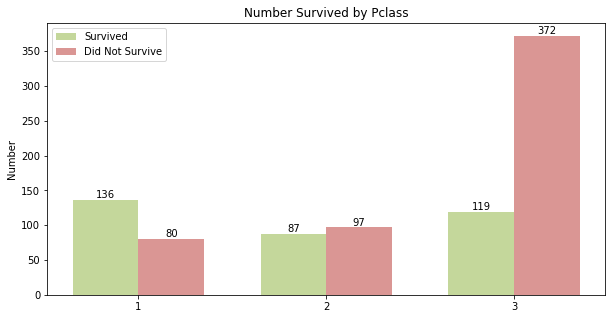

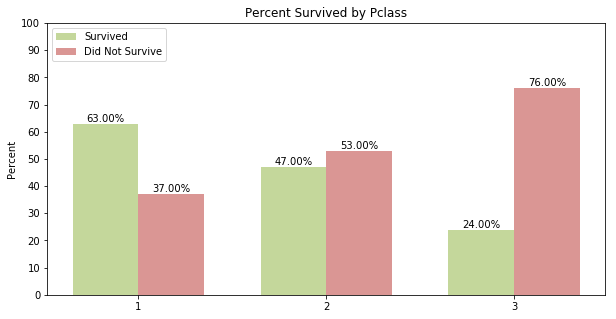

,Number Survived,Number Lost,Total,Percent Survived,Percent Lost
Pclass,,,,,
1,136,80,216,63,37
2,87,97,184,47,53
3,119,372,491,24,76


In [28]:
#creat the table
tb=createSurvivalTable(titanic_df,'Pclass')
#create the bar chart
getBarChartOfNumberSurvived(tb,'Number Survived by Pclass',10.0,5.0, 'upper left')
getBarChartOfPercentSurvived(tb,'Percent Survived by Pclass',10.0,5.0, 'upper left')
#show the graph
plt.show()
#print the table    
tb

From the data above we can gather that Pclass (proxy for socio-economic status) does appear to have the capability to help predict survival rates. Specifically it appears that the lower the Pclass the less likely they were to survive. This column will be used further in the next section as it clearly might effect survival rate.

<h4  id="OneDimGender" >6.2 Gender</h4>

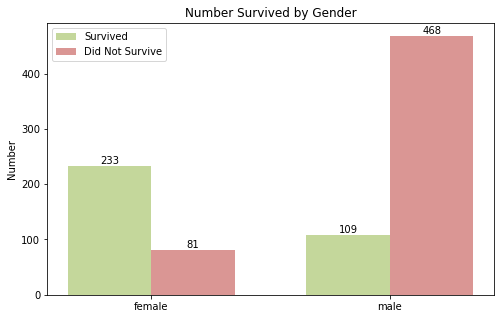

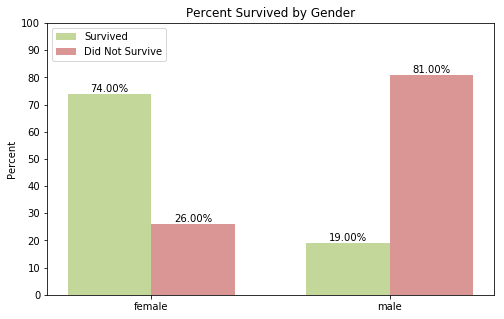

,Number Survived,Number Lost,Total,Percent Survived,Percent Lost
Sex,,,,,
female,233,81,314,74,26
male,109,468,577,19,81


In [29]:
#creat the table
tb=createSurvivalTable(titanic_df,'Sex')
#create the bar chart
getBarChartOfNumberSurvived(tb,'Number Survived by Gender',8.0,5.0, 'upper left')
getBarChartOfPercentSurvived(tb,'Percent Survived by Gender',8.0,5.0, 'upper left')
#show the graph
plt.show()
#print the table    
tb

Using the data above it is likely that gender will also play an important role in predicting survival as far more females than males survived.

<h4  id="OneDimSibSp">6.3 SibSp</h4>

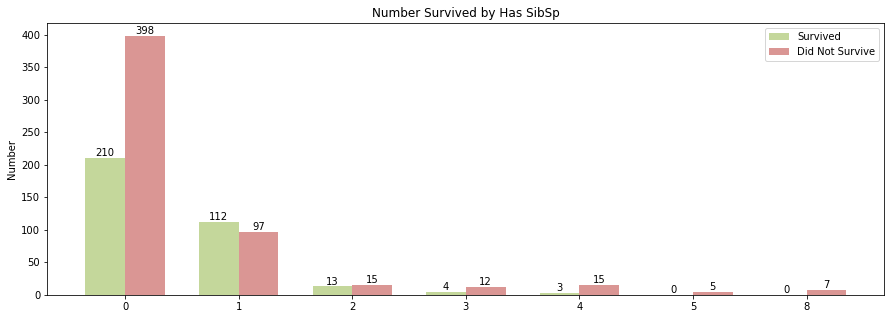

,Number Survived,Number Lost,Total,Percent Survived,Percent Lost
SibSp,,,,,
0,210,398,608,35,65
1,112,97,209,54,46
2,13,15,28,46,54
3,4,12,16,25,75
4,3,15,18,17,83
5,0,5,5,0,100
8,0,7,7,0,100


In [30]:
#create the table
tb=createSurvivalTable(titanic_df,'SibSp')
#create the bar chart
getBarChartOfNumberSurvived(tb,'Number Survived by Has SibSp',15.0,5.0, 'upper right')
#show the graph
plt.show()
#print the table    
tb

The data displayed on this graph is a bit more unclear than the previous columns. Due to the limited data we have for passengers with 2+ SibSp it might be better to instead look at it as simply if they have a spouse or siblings. The percent graph was emitted due to it being misleading.

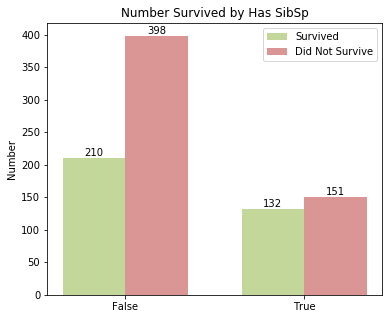

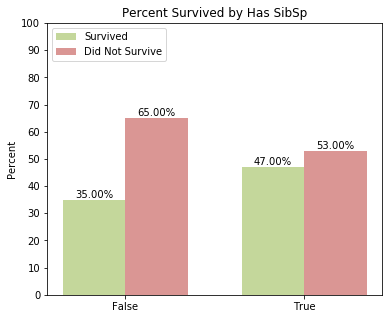

,Number Survived,Number Lost,Total,Percent Survived,Percent Lost
Has SibSp,,,,,
False,210,398,608,35,65
True,132,151,283,47,53


In [31]:
#create new column to check for sibling or spouse
titanic_df['Has SibSp'] = titanic_df['SibSp'] > 0
#create the table
tb=createSurvivalTable(titanic_df,'Has SibSp')
#create the bar chart
getBarChartOfNumberSurvived(tb,'Number Survived by Has SibSp',6.0,5.0, 'upper right')
getBarChartOfPercentSurvived(tb,'Percent Survived by Has SibSp',6.0,5.0, 'upper left')
#show the graph
plt.show()
#print the table    
tb

Looking at the data in this manner it appears that having a SibSp indicates that there is a slightly higher chance of survival. This column will be used instead of SibSp in the next section.

<h4  id="OneDimParch">6.4 Parch</h4>

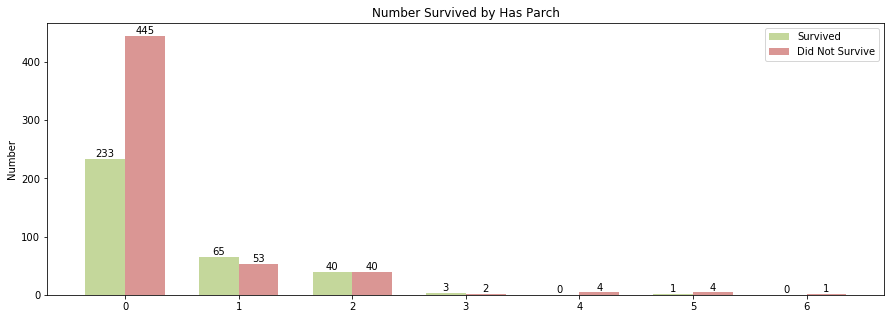

,Number Survived,Number Lost,Total,Percent Survived,Percent Lost
Parch,,,,,
0,233,445,678,34,66
1,65,53,118,55,45
2,40,40,80,50,50
3,3,2,5,60,40
4,0,4,4,0,100
5,1,4,5,20,80
6,0,1,1,0,100


In [32]:
#creat the table
tb=createSurvivalTable(titanic_df,'Parch')
#create the bar chart
getBarChartOfNumberSurvived(tb,'Number Survived by Has Parch',15.0,5.0, 'upper right')
#show the graph
plt.show()
#print the table    
tb

This data also appears to have the same issues as the one above, so a similar check is preformed. The percent graph was emitted due to it being misleading.

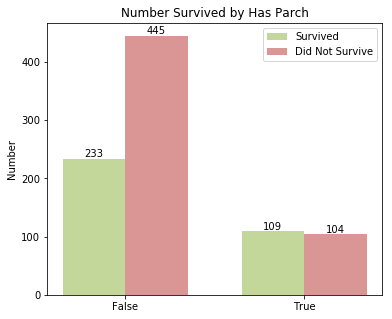

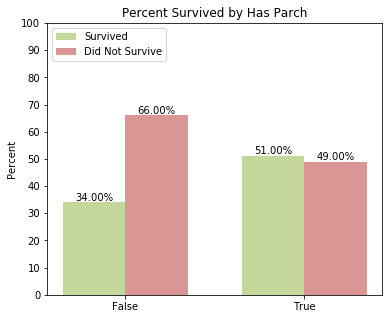

,Number Survived,Number Lost,Total,Percent Survived,Percent Lost
Has Parch,,,,,
False,233,445,678,34,66
True,109,104,213,51,49


In [33]:
#create new column to check for sibling or spouse
titanic_df['Has Parch'] = titanic_df['Parch'] > 0
#create the table
tb=createSurvivalTable(titanic_df,'Has Parch')
#create the bar chart
getBarChartOfNumberSurvived(tb,'Number Survived by Has Parch',6.0,5.0, 'upper right')
getBarChartOfPercentSurvived(tb,'Percent Survived by Has Parch',6.0,5.0, 'upper left')
#show the graph
plt.show()
#print the table    
tb

Again this is similar to the above data in that it appears better to use this simplified column in the next section. 

<h4  id="OneDimAge">6.5 Number Passengers with the Same Ticket ID</h4>

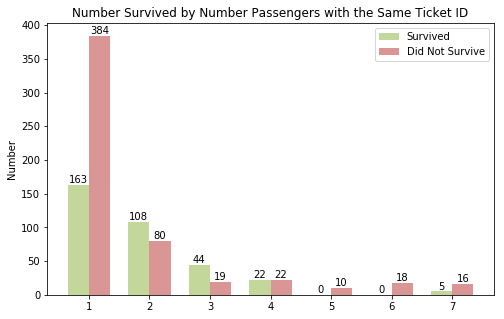

,Number Survived,Number Lost,Total,Percent Survived,Percent Lost
NumPassWithSameTicket,,,,,
1,163,384,547,30,70
2,108,80,188,57,43
3,44,19,63,70,30
4,22,22,44,50,50
5,0,10,10,0,100
6,0,18,18,0,100
7,5,16,21,24,76


In [34]:
#create the table
tb=createSurvivalTable(titanic_df,'NumPassWithSameTicket')
#create the bar chart
getBarChartOfNumberSurvived(tb,'Number Survived by Number Passengers with the Same Ticket ID',8.0,5.0, 'upper right')
#show the graph
plt.show()
#print the table    
tb

This data also appears to have the same issues as the one above, so a similar check is preformed. The percent graph was emitted due to it being misleading.

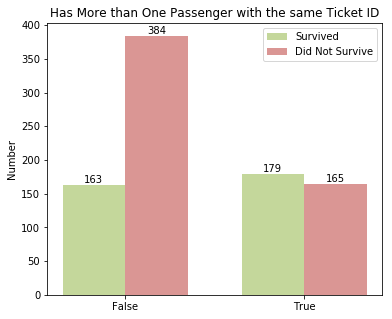

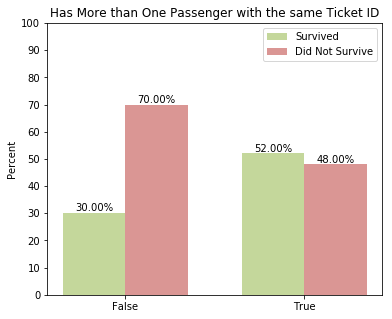

,Number Survived,Number Lost,Total,Percent Survived,Percent Lost
Has More than One Passenger with the same Ticket ID,,,,,
False,163,384,547,30,70
True,179,165,344,52,48


In [35]:
#create new column
titanic_df['Has More than One Passenger with the same Ticket ID'] = titanic_df['NumPassWithSameTicket'] > 1
#create the table
tb=createSurvivalTable(titanic_df,'Has More than One Passenger with the same Ticket ID')
#create the bar chart
getBarChartOfNumberSurvived(tb,'Has More than One Passenger with the same Ticket ID',6.0,5.0, 'upper right')
getBarChartOfPercentSurvived(tb,'Has More than One Passenger with the same Ticket ID',6.0,5.0, 'upper right')
#show the graph
plt.show()
#print the table    
tb

Again this is similar to the above data in that it appears better to use this simplified column in the next section. 

<h4  id="OneDimAge">6.6 Age</h4>

Age is a bit different from the previous data column due to the range of values that it can appear. In order better group the data it will be split into bins of ten. (ie 0-9,10-19 etc). It is also said that children were given priority for life rafts, so it could be expected that they would have higher survival rates. To examine this a new column "Under18" will be added. For the purposes of this analysis the fact that some of these ages are estimates will not be taken into account and the rows with missing data will not be used.

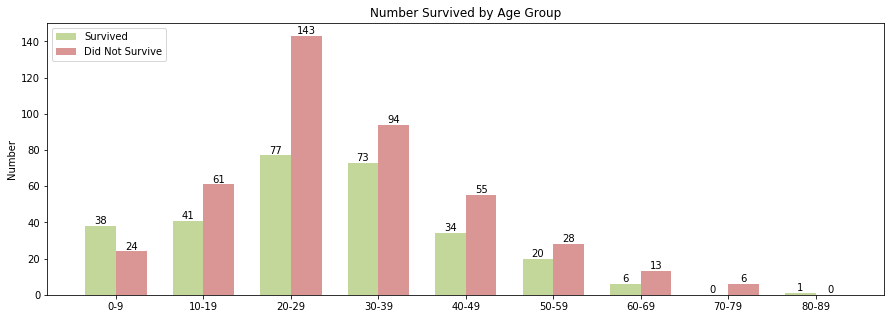

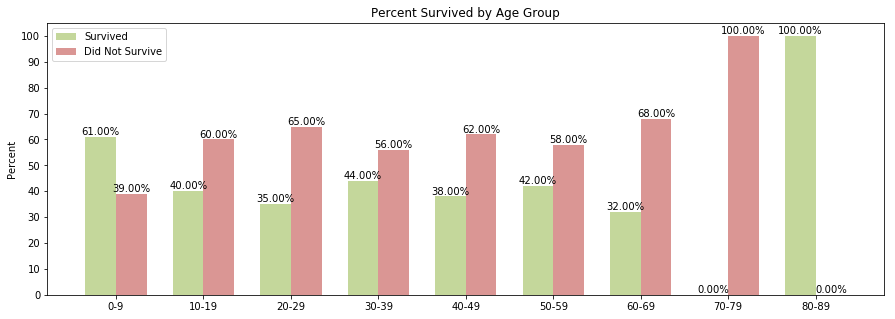

,Number Survived,Number Lost,Total,Percent Survived,Percent Lost
AgeGroups,,,,,
0-9,38,24,62,61,39
10-19,41,61,102,40,60
20-29,77,143,220,35,65
30-39,73,94,167,44,56
40-49,34,55,89,38,62
50-59,20,28,48,42,58
60-69,6,13,19,32,68
70-79,0,6,6,0,100
80-89,1,0,1,100,0


In [36]:
titanic_df['AgeGroups']= titanic_df['Age'].apply(setAgeGroups)
#creat the table
tb=createSurvivalTable(titanic_df,'AgeGroups')
#create the bar chart
getBarChartOfNumberSurvived(tb,'Number Survived by Age Group',15.0,5.0, 'upper left')
getBarChartOfPercentSurvived(tb,'Percent Survived by Age Group',15.0,5.0, 'upper left')
#show the graph
plt.show()
#print the table    
tb

Aside from the ages 0-9 and 70+ the survival rates seem to be similar. 70+ though can be explained from the fact that there is so little data for them. It appears that children where more likely to survive. Therefore it makes more sense to seperate the data out into children and non-children. Everyone under 18 will be considered a child and everyone else an adult.

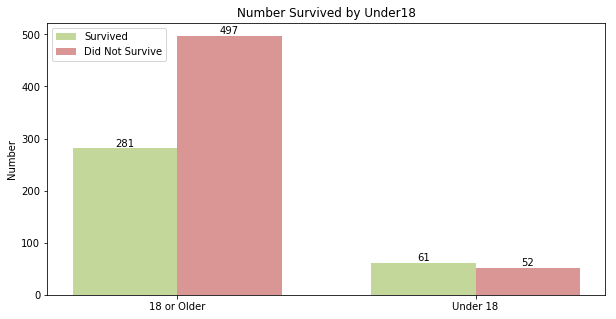

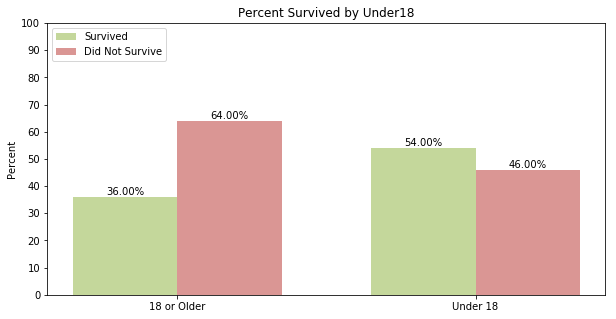

,Number Survived,Number Lost,Total,Percent Survived,Percent Lost
Under18,,,,,
18 or Older,281,497,778,36,64
Under 18,61,52,113,54,46


In [37]:
titanic_df['Under18'] = titanic_df['Age'].apply(setUnderXAgeText, args=(18,))
#create the table
tb=createSurvivalTable(titanic_df,'Under18')
#create the bar chart
getBarChartOfNumberSurvived(tb,'Number Survived by Under18',10.0,5.0, 'upper left')
getBarChartOfPercentSurvived(tb,'Percent Survived by Under18',10.0,5.0, 'upper left')
#show the graph
plt.show()
#print the table    
tb

Examining the above it appears that there might be a correlation between those who are children and those who are not. This will be examined more in the next section.

<h4 id="OneDimFare">6.7 Fare</h4>
The fare has the same issues as age since it is a continous variable. However, it is more difficult to split up than age as there is no easy way to decide the bin size. In order to determine bin size a summary of the Fare data will be printed out

In [38]:
pd.DataFrame(titanic_df['Fare'].describe())

,Fare
count,891
mean,32
std,50
min,0
25%,8
50%,14
75%,31
max,512


The descriptive statistics above indicate that there is a farely wide range of fares that are skewed to the left. Due to the skewing of this data using the standard deviation would not be efficent to use. Instead the data will be split up by percentiles of 10%.

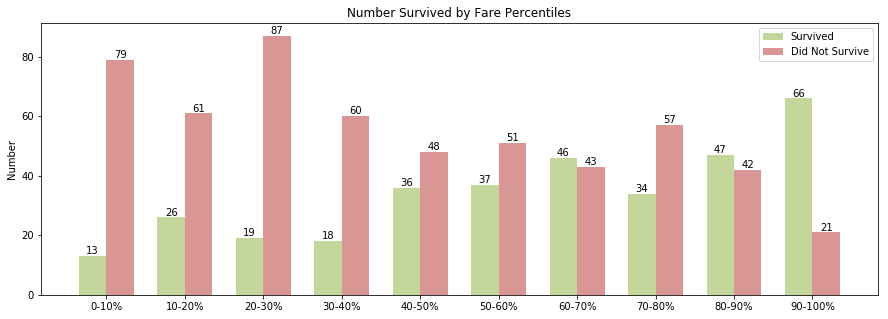

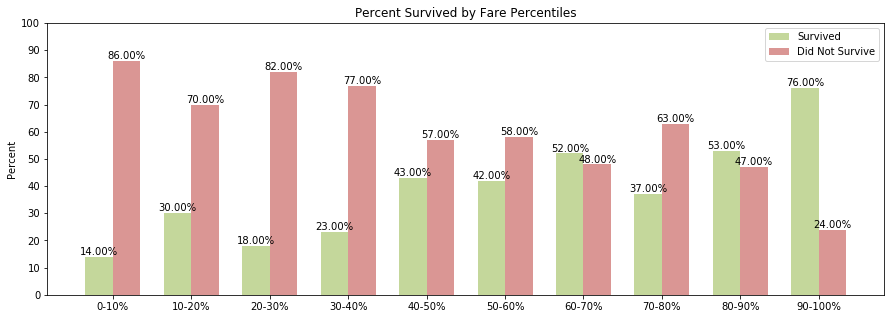

,Number Survived,Number Lost,Total,Percent Survived,Percent Lost
FarePercentiles,,,,,
0-10%,13,79,92,14,86
10-20%,26,61,87,30,70
20-30%,19,87,106,18,82
30-40%,18,60,78,23,77
40-50%,36,48,84,43,57
50-60%,37,51,88,42,58
60-70%,46,43,89,52,48
70-80%,34,57,91,37,63
80-90%,47,42,89,53,47


In [39]:
percentiles = [.1,.2,.3,.4,.5,.6,.7,.8,.9,1]
titanic_df['FarePercentiles'] = titanic_df['Fare'].apply(setCreatePercentilesCol, args=(percentiles, titanic_df['Fare'],))

#create the table
tb=createSurvivalTable(titanic_df,'FarePercentiles')
#create the bar chart
getBarChartOfNumberSurvived(tb,'Number Survived by Fare Percentiles',15.0,5.0, 'upper right')
getBarChartOfPercentSurvived(tb,'Percent Survived by Fare Percentiles',15.0,5.0, 'upper right')
#show the graph
plt.show()
#print the table    
tb

As shown in the table and graphs it appears that those who paid in the lowest 40% were less likely to survive. The results seem to indicate the same message as the pclass column where the richer a passenger the more likely they are to survive.

<h4  id="OneDimEmbarked">6.8 Embarked</h4>
The two rows with missing vlaues will not be used in this section. 

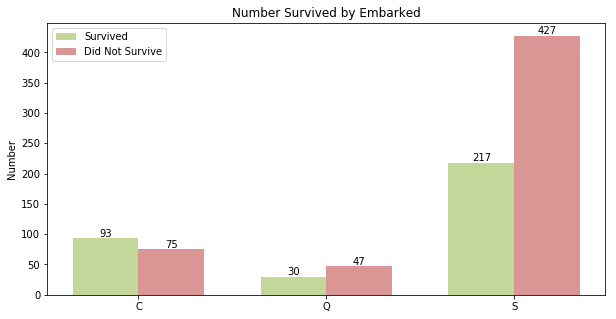

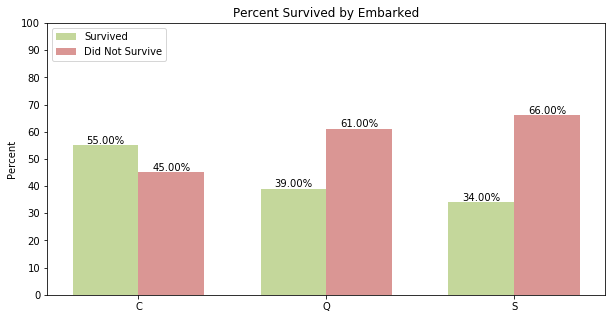

,Number Survived,Number Lost,Total,Percent Survived,Percent Lost
Embarked,,,,,
C,93,75,168,55,45
Q,30,47,77,39,61
S,217,427,644,34,66


In [40]:
#create the table
tb=createSurvivalTable(titanic_df,'Embarked')
#create the bar chart
getBarChartOfNumberSurvived(tb,'Number Survived by Embarked',10.0,5.0, 'upper left')
getBarChartOfPercentSurvived(tb,'Percent Survived by Embarked',10.0,5.0, 'upper left')
#show the graph
plt.show()
#print the table    
tb

The appearance of the above data suggests that the location of Embarkment may also have something to do with the survival rate.

<h4  id="OneDimSectionSummary">6.9 Section Summary</h4>
The following is a brief summary of what was seen above.
* Pclass by Survival - The data suggests that the higher the Pclass the more likely a passenger was to survive. (The highest is Pclass 1) 
* Sex by Survival - The data suggests that woman were more likely to survive the titanic. 
* SibSp by Survival - This data suggests that passengers that have at least one SibSp were more likely to survive than those that don't. 
* Parch by Survival - This data suggests that passengers that have at least one Parch were more likely to survive than those that don't.
* Number Passengers with the Same Ticket ID - This data suggests that passengers that have at least one other passenger with the same ticket ID were more likely to survive.
* Age by Survival - This data suggests that passengers under the age of 18 were more likely to survive than those who are older. 
* Fare by Survival - This data suggests that those that are in the top 50% of the fare price were more likely to survive.
* Embarked by Survival - This data suggest that if the passenger embarked from Cherbourg they were more likely to survive. 

Looking at the data it is possible to loosely rank these traits in this order based on percent survived in this data set: 
1. Fare - Those that paid in the top 10% of fares. (76% survived)
2. Sex - Women (75% survived)
3. Pclass - 1 (63% survived)
4. Embarked - Cherbourg (55% survived)
5. Age - Passengers Under 18 (54% survived)
6. Number of Passengers with the Same Ticket ID - Passengers that have at least one other passenger with the same ticket ID (52% survived)
7. Parch - Those that have at least one Parch (51% survived)
8. SibSp - Those that have at least one SibSp (47% survived)

or they can be losely arranged by the total number that survived
1. Age - Passengers over Under 18 (281 survived)
2. Sex - Women (233 survived) 
2. Parch - Those that dont have a Parch (233 survived)
3. Embarked - Southampton (217 survived)
4. SibSp - Those that don't have a SibSp (210 survived)
5. Number of Passengers with the Same Ticket ID - Passengers that have no other passengers with the same ticket ID (163 survived)
6. Pclass - 1 (136 survived)
7. Fare - Those that paid in the top 10% of fares. (66 survived)

<h3 id="MultiDimIntro">7. Multi-Dimensional Analysis of Columns By Survival</h3>
This section will examine how the factors outlined in the summary in section 6 interact with each other and survival rate. This will be examined in two different ways. The first two ways will use percent survived as the basis of picking traits while the second two will use the total number of survived. (Both are outlined in section 5.9) These two catagories will be looked at by examining the survival rate against the number of traits a passenger has.

In order to easly accomplish this a new table will be created with the traits in binary. True for having and False for not having the trait. 

In [66]:
#create a new table with only the columns that are needed
hasTrait = titanic_df[['PassengerId','Survived','FarePercentiles', 'Sex','Pclass', 'Embarked','Under18','Has Parch','Has SibSp',
                       'Has More than One Passenger with the same Ticket ID']]
#Change the variables that need to be changed to true and false
hasTrait = pd.DataFrame(hasTrait)
hasTrait['FarePercentilesAt90_100'] = hasTrait['FarePercentiles'] == "90-100%"
hasTrait['sexFemale'] = hasTrait['Sex'] == "female"
hasTrait['Pclass1'] = (hasTrait['Pclass'] == 1)
hasTrait['EmbarkedC'] = hasTrait['Embarked'] == "C"
hasTrait['IsUnder18'] = hasTrait['Under18'] != "18 or Older"
hasTrait['Is18orOlder'] = hasTrait['Under18'] == "18 or Older"
hasTrait['EmbarkedS'] = hasTrait['Embarked'] == "S"
hasTrait['One Passenger with the Ticket ID'] = hasTrait['Has More than One Passenger with the same Ticket ID'] == False
hasTrait['NoParch'] = hasTrait['Has Parch']  == False
hasTrait['NoSibSp'] = hasTrait['Has SibSp']  == False

#identify only the columns that were turned into true and false
hasTrait = pd.DataFrame(hasTrait[['PassengerId','Survived','FarePercentilesAt90_100', 'sexFemale','Pclass1', 'EmbarkedC',
                        'IsUnder18','Has Parch','Has SibSp',
                        'Has More than One Passenger with the same Ticket ID', 'Is18orOlder','EmbarkedS',
                                  'One Passenger with the Ticket ID', 'NoParch', 'NoSibSp']])

hasTrait['howManyTraitsByPerc'] = hasTrait['FarePercentilesAt90_100'].astype(int) +  hasTrait['Pclass1'].astype(int) + hasTrait['sexFemale'].astype(int) +  hasTrait['EmbarkedC'].astype(int) +  hasTrait['IsUnder18'].astype(int) +hasTrait['Has Parch'].astype(int) +  hasTrait['Has SibSp'].astype(int) + hasTrait['Has More than One Passenger with the same Ticket ID'].astype(int)
hasTrait['howManyTraitsByTotal'] = hasTrait['FarePercentilesAt90_100'].astype(int) +  hasTrait['Pclass1'].astype(int) + hasTrait['sexFemale'].astype(int) +  hasTrait['EmbarkedS'].astype(int) +  hasTrait['Is18orOlder'].astype(int) +hasTrait['NoParch'].astype(int) +  hasTrait['NoSibSp'].astype(int) + hasTrait['One Passenger with the Ticket ID'].astype(int)


<h4 id="MultiDimFunctions">7.0 Functions</h4>

In [67]:
#Note: This section will make use of the createSurvivalTable that was created in the last section

In [68]:
def createTotalSurvivalRatebyTraitPlot(df, chartTitle):
    #Summary:Gives a a line chart of the total survival rate by the number of traits a passenger has
    #input:
        #df - A pd dataframe of the count of the passangers grouped by survived and the number of traits they have
        #chartTitle - The title of the chart
    #output: A line chart of the survial rate by the number of traits a passenger has
    plt.plot(tb.index, tb['Number Survived'], marker='o')
    plt.plot(tb.index, tb['Number Lost'], marker='o')
    plt.title("Total Number of Traits vs Suvival Rate")
    plt.xticks([0, 1, 2, 3,4,5,6,7,8])
    plt.legend()
    


In [69]:
def createPercSurvivalRatebyTraitPlot(df, chartTitle):
    #Summary:Gives a a line chart of the percent survival rate by the number of traits a passenger has
    #input:
        #df - A pd dataframe of the count of the passangers grouped by survived and the number of traits they have
        #chartTitle - The title of the chart
    #output: A line chart of the survial rate by the number of traits a passenger has
    plt.plot(tb.index, tb['Percent Survived'], marker='o')
    plt.plot(tb.index, tb['Percent Lost'], marker='o')
    plt.title("Number of Traits vs Suvival Rate by Percent")
    plt.xticks([0, 1, 2, 3,4,5,6,7,8])
    plt.legend()

<h4 id="MultiDimPercTraitsPerc">7.1 Total Number of Traits a Passenger has (Traits based on Percent)</h4>

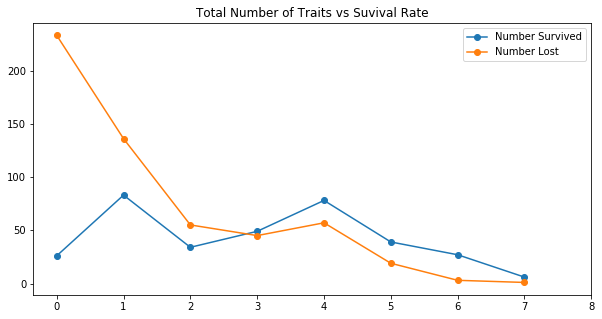

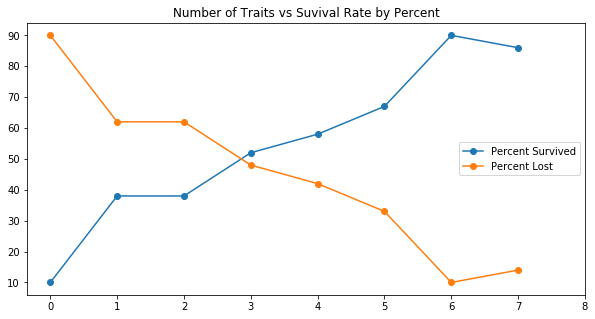

,Number Survived,Number Lost,Total,Percent Survived,Percent Lost
howManyTraitsByPerc,,,,,
0,26,233,259,10,90
1,83,136,219,38,62
2,34,55,89,38,62
3,49,45,94,52,48
4,78,57,135,58,42
5,39,19,58,67,33
6,27,3,30,90,10
7,6,1,7,86,14


In [70]:
#create the table
tb=createSurvivalTable(hasTrait,'howManyTraitsByPerc')
createTotalSurvivalRatebyTraitPlot(tb, "Totals")
plt.show()
createPercSurvivalRatebyTraitPlot(tb, "Percents")
plt.show()

tb

As expected the more traits that a passenger has from this set of traits the more likely they were to survive. This looks like it might be a positive regression, so it makes sense to apply a multi-variable linear regression to these traits.

In [71]:
#get the traits
X=hasTrait[["FarePercentilesAt90_100", "sexFemale", "Pclass1", "EmbarkedC","IsUnder18","Has Parch","Has SibSp",
                        "Has More than One Passenger with the same Ticket ID"]] 
Y=hasTrait['Survived'] 
model = sm.OLS(Y,X)
#
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               Survived   R-squared:                       0.594
Model:                            OLS   Adj. R-squared:                  0.590
Method:                 Least Squares   F-statistic:                     161.2
Date:                Mon, 18 Sep 2017   Prob (F-statistic):          6.54e-167
Time:                        21:34:02   Log-Likelihood:                -436.50
No. Observations:                 891   AIC:                             889.0
Df Residuals:                     883   BIC:                             927.3
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------

The model details provided above show that a female is 57% more likely to survive than a male, on average, all else equal. It also indicates a positive correlation for being in Pclass 1, embarked from Cherbourg, and being under 18. The other coefficients, fare, Parch, Sibsp, and ticket ID are not significant in this model. However, the models adjusted R squared value is 0.590, which means that it would be hard to accurately predict if a passenger survived just by being given these traits. 

<h4 id="MultiDimPercTraitsTotal">7.2 Total Number of Traits a Passenger has (Traits based on Total Survived)</h4>

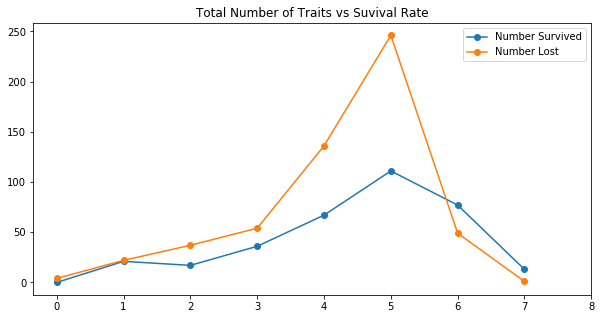

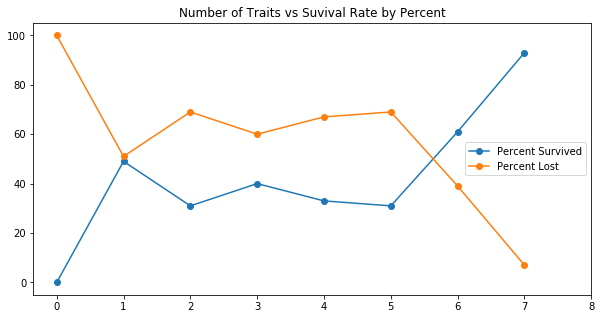

,Number Survived,Number Lost,Total,Percent Survived,Percent Lost
howManyTraitsByTotal,,,,,
0,0,4,4,0,100
1,21,22,43,49,51
2,17,37,54,31,69
3,36,54,90,40,60
4,67,136,203,33,67
5,111,246,357,31,69
6,77,49,126,61,39
7,13,1,14,93,7


In [72]:
#create the table
tb=createSurvivalTable(hasTrait,'howManyTraitsByTotal')
createTotalSurvivalRatebyTraitPlot(tb, "Totals")
plt.show()
createPercSurvivalRatebyTraitPlot(tb, "Percents")
plt.show()

tb

Like the traits that were choses based on survival percentages these traits will also be placed in a multi-linear regression model. 

In [73]:
#get the traits
X=hasTrait[["FarePercentilesAt90_100", "sexFemale", "Pclass1", "EmbarkedS","Is18orOlder","NoParch","NoSibSp",
                        "One Passenger with the Ticket ID"]] 

Y=hasTrait['Survived'] 
model = sm.OLS(Y,X)
#
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               Survived   R-squared:                       0.593
Model:                            OLS   Adj. R-squared:                  0.589
Method:                 Least Squares   F-statistic:                     160.8
Date:                Mon, 18 Sep 2017   Prob (F-statistic):          1.26e-166
Time:                        22:02:24   Log-Likelihood:                -437.17
No. Observations:                 891   AIC:                             890.3
Df Residuals:                     883   BIC:                             928.7
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
FarePerc

Being female and being in pclass 1 are still significant in this model. However, this model suffers the same fate as the first model in that the adjusted R-squared value is not very high, which means this model will not be particularly accurate in predicting survival rates based on these traits.

<h4  id="MultiDimSectionSummary">7.3 Section Summary</h4>
In summary this section examined how the number of traits that were identified in section 6.13 affected the survival rate of passengers. No passengers had all of the traits in either of the two sets of traits that were identifed. The more traits that someone had when the traits were choses by percent survived the higher the likelyhood of their survival. Both sets of traits were then fit to a multi-linear regression model. The models had an adjusted R squared value of around .59, which indicates that they will not perform too well when used to predict if a passenger survives given a set of traits. It should be noted that in both models being female and being in Pclass 1 indicated increased survival rate at an acceptable significance level. 

<h4  id="Conclusion">8.0 Conclusion</h4>
The original question of this analysis was to examine the dataset that was given and determine what variables helped predict survival rate. In section 6 the individual traits were looked at and in the section summary two sets of traits were created. One was create based on the survival percentages of the individual traits (the highest rates where used). The other was created based off of the total number of survivers (the traits with the most survivor were used). These two sets of traits were then fit to their own multi-variable linear regression model. In both models being female and being in Pclass 1 indicated increased survival rate at an acceptable significance level. The "female" trait in both models indicated that females were 57% more likely to survive than a male, on average, all else equal. However, each model had an adjusted r-squared of around .59, which means they would not necessarly be great a predicting if any given passenger survived.<br>
<br>
While it is not possible to use these models to predict if any given passenger had survived they are able to help indicate traits that might be useful in building future models. Given the output from the above models I would recommend that anyone looking to build additional models should look at the following traits: 
* Sex - Female (Significant in model 1 and 2)
* Pclass - One (Significant in model 1 and 2)
* Embarked - Cherbourg (Significant in model 1)
* Age - Passengers Under 18 (Significant in model 1)

<h4  id="References">9.0 References</h4>
Various questions that others posted on forms and documented API